In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
import time
import numpy as np
import cv2
from PIL import Image
import os
from matplotlib import pyplot as plt
#from resotrmer import Restormer_Denoise
from models_DnCNN import DnCNN_Denoiser
from denoise_classical import GaussianBlur, MedianBlur
import shutil
from copy import deepcopy
import pickle
import seaborn as sns
import pandas as pd
import traceback
import random
#from glob import glob



#Turn all the randomisation off to ensure the results of every execution is the same 
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

torch.cuda.empty_cache()
#torch.cuda.reset_peak_memory_stats()

### Define variables

In [3]:
IMG_SIZE = 224
FOLDER_PATH = "Images/100"

#restomer = Restormer_Denoise("blind")
#dncnn = DnCNN_Denoiser()

denoise_methods = {
    "None": lambda x:x,
    #"Restormer": restomer.denoise_image,
    "Gaussian_Blur": GaussianBlur,
    "Median_Blur": MedianBlur,
    #"DnCNN": dncnn.denoise_image
}

classification_models = ["CNN", "KNN", "SVM", "Random Forest"]

models_denoising_accuracies = {model: {denoise_method: -1 for denoise_method in denoise_methods.keys()}  # -1 represent not yet calculated
                               for model in classification_models}
models_denoising_f1_scores = {model: {denoise_method: -1 for denoise_method in denoise_methods.keys()}  # -1 represent not yet calculated
                               for model in classification_models}
models_denoising_classification_times = {model: {denoise_method: -1 for denoise_method in denoise_methods.keys()}  # -1 represent not yet calculated
                               for model in classification_models}
models_denoising_confusion_metrics = {model: {denoise_method: -1 for denoise_method in denoise_methods.keys()}  # -1 represent not yet calculated
                               for model in classification_models}

def build_transform(denoise_method: str) -> transforms.Compose:
    denoise_fn = denoise_methods.get(denoise_method, lambda x:x)

    return transforms.Compose([
        transforms.Lambda(denoise_fn),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

### Preprocessing: Merge labels(**Only** execute the following cell if you haven't merge the folders)

In [1]:
# each list argument contains some subfolders, this function merge all images in subfolders into one big folder
# list1: immune cells class
# list2: non-invasive tumor
# list3: invasive tumor
def merge_folder(list1, list2, list3):
    # define folder paths
    source_path = './Images/100/'

    immune_cells = list1

    non_invasive_tumor = list2

    invasive_tumor_cell = list3

    folder_dests = ["Immune_Cells", "Non_Invasive_Tumor", "Invasive_Tumor_Set"]

    # make empty folder
    for i in folder_dests:
        dest_path = source_path + i
        os.makedirs(dest_path, exist_ok=True)
        print(f"{dest_path} is created.")

    # start copying file process
    source_categories = [immune_cells, non_invasive_tumor, invasive_tumor_cell]
    extensions = '*.png'

    count = 1
    cate_count = 0
    for source_dirs in source_categories:
        for src in source_dirs:
            pattern = os.path.join(source_path+src, extensions)
            print(pattern)
            for img_path in glob.glob(pattern):
                print(img_path)
                filename = os.path.basename(img_path)
                dest_path = source_path + folder_dests[cate_count]
                file_dest_path = os.path.join(dest_path, filename)
                # copying images from sub-folder to big folder, (overwirte if same images exist)
                shutil.copy2(img_path, file_dest_path)
                print(f'{count}: Copied {img_path} -> {file_dest_path}')
                count += 1
        cate_count += 1
    return 0

merge_folder(['B_Cells','CD4+_T_Cells'], ['DCIS_1', 'DCIS_2'], ['Invasive_Tumor', 'Prolif_Invasive_Tumor'])

NameError: name 'os' is not defined

### Define Image Dataset structure and image transform

In [4]:
class ImageDataSet(Dataset):
    def __init__(self, image_names, transform):
        self.file_names = []
        self.labels = []
        for numeric_label, names in enumerate(image_names):
            self.labels.extend([numeric_label]*len(names))
            self.file_names.extend(names)

        self.transform = transform

    def __getitem__(self, index):
        img_name = self.file_names[index]
        img = Image.open(img_name).convert('RGB')
        img = self.transform(img)
        label = self.labels[index]
        return img, label
    
    def __len__(self):
        return len(self.file_names)

# labels = ["B_Cells", "CD4+_T_Cells", "DCIS_1", "DCIS_2", "Invasive_Tumor", "Prolif_Invasive_Tumor"]
labels = ["Immune_Cells", "Non_Invasive_Tumor", "Invasive_Tumor_Set"]
le = LabelEncoder()
numeric_labels = le.fit_transform(labels)
image_names = []
for _ in numeric_labels:
    image_names.append([])

for (dir_path, dir_names, file_names) in os.walk(FOLDER_PATH):
    parent_folder = os.path.basename(dir_path)
    if parent_folder in labels: # Read the subset of dataset to reduce training time 
        for file in file_names:
            image = cv2.imread(os.path.join(dir_path, file))
            if image.shape[0] < 100 and image.shape[1] < 100: #skip the small image, it doesn't give much info
                continue
            numeric_label = le.transform([parent_folder])[0]
            image_names[numeric_label].append(os.path.join(dir_path, file))


#denoising_datasets = {key : ImageDataSet(image_names, build_transform(key)) for key in denoise_methods.keys()}

# toy dataset
toy_set_names = []
for names in image_names:
    # randomly select 10%
    subset_size = 0.1
    k = max(1, int(subset_size * len(names)))
    toy_set_names.append(random.sample(names, k))
denoising_datasets = {key : ImageDataSet(toy_set_names, build_transform(key)) for key in denoise_methods.keys()}

In [5]:
# dataset total size for each category
for names in image_names:
    n = max(1, int(len(names)))
    print(n)

13440
38149
24606


## CNN model

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #check if the computer has GPU

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(image_names))
model = model.to(device)

denoising_cnn_models = {key : deepcopy(model).to(device) for key in denoise_methods.keys()}

/home/falzgrandma/venvs/torch_rocm/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/falzgrandma/venvs/torch_rocm/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #check if the computer has GPU

if torch.cuda.is_available():
    print("CUDA is available")
    # You can proceed to verify GPU properties
else:
    print("CUDA is not available")
    # PyTorch might not be utilizing the AMD GPU or other GPU


if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0) # 0 is the default device
    print(f"GPU name: {device_name}")
    device_properties = torch.cuda.get_device_properties(0)
    print(device_properties)

CUDA is not available


In [8]:
# hyper-parameters setting
num_epochs = 100
patience = 10 #for early stopping
batch_size = 128
learning_rate = 0.001

In [9]:
def split_dataset(dataset: ImageDataSet):
    train_idx, temp_idx = train_test_split(list(range(len(dataset))), test_size=0.3, random_state=0)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=0)

    print(len(train_idx))
    print(len(temp_idx))
    print(len(val_idx))

    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    test_subset = Subset(dataset, test_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

    return train_loader, val_loader, test_loader

### CNN Model training

In [9]:
training_loss_curves = {key : [] for key in denoise_methods.keys()}
val_loss_curves = {key : [] for key in denoise_methods.keys()}

for denoise, model in denoising_cnn_models.items():
    print(f"Start training {denoise} model.")
    best_val_loss = float('inf')
    epoch_no_improvement = 0
    best_model_parameters = None
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loader, val_loader, _ = split_dataset(denoising_datasets.get(denoise))
    try:
        scaler = torch.amp.GradScaler()
        for epoch in range(num_epochs):
            # Training phase
            model.train()
            running_loss = 0.0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                
                optimizer.zero_grad()

                with torch.amp.autocast("cuda"):
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                # outputs = model(images)
                # loss = criterion(outputs, labels)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                # loss.backward()
                # optimizer.step()

                print(f"Batch loss: {loss}")
                
                running_loss += loss.item()
            
            training_loss = running_loss/len(train_loader)
            training_loss_curves[denoise].append(training_loss)
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {training_loss:.4f}")
            
            # Validation phase
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0
            
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            
            avg_val_loss = val_loss/len(val_loader)
            val_accuracy = 100 * correct / total
            print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")
            val_loss_curves[denoise].append(avg_val_loss)

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model_parameters = model.state_dict()
                epoch_no_improvement = 0
            else:
                epoch_no_improvement += 1
                if epoch_no_improvement == patience:
                    print(f"No improvement for {patience} epoches. Early stopping.")
                    break

        if best_model_parameters is not None:
            model.load_state_dict(best_model_parameters)
    except Exception as e:
        traceback.print_exc()
        # torch.save(model.state_dict(), f'CNN_{denoise}.pth')

Start training None model.


/home/falzgrandma/venvs/torch_rocm/lib/python3.12/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/falzgrandma/venvs/torch_rocm/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/falzgrandma/venvs/torch_rocm/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Batch loss: 1.284135341644287
Batch loss: 0.6855536103248596
Batch loss: 0.6943813562393188
Batch loss: 0.6939305663108826
Batch loss: 0.5582002997398376
Batch loss: 0.5074259042739868
Batch loss: 1.019144892692566
Batch loss: 0.5984938144683838
Batch loss: 0.6779911518096924
Batch loss: 0.42383915185928345
Batch loss: 0.5571345090866089
Batch loss: 0.4899900555610657
Batch loss: 0.44944360852241516
Batch loss: 0.7300111651420593
Batch loss: 0.4895065724849701
Batch loss: 0.44679397344589233
Batch loss: 0.30481213331222534
Batch loss: 0.36908018589019775
Batch loss: 0.3026810586452484
Batch loss: 0.47486257553100586
Batch loss: 0.46612098813056946
Batch loss: 0.3421182930469513
Batch loss: 0.2919856607913971
Batch loss: 0.3899948298931122
Batch loss: 0.31888288259506226
Batch loss: 0.2262706309556961
Batch loss: 0.43046078085899353
Batch loss: 0.3185242712497711
Batch loss: 0.27556487917900085
Batch loss: 0.28116878867149353
Batch loss: 0.3946831524372101
Batch loss: 0.3596433997154236

KeyboardInterrupt: 

In [ ]:
training_loss_curves = {key : [] for key in denoise_methods.keys()}
val_loss_curves = {key : [] for key in denoise_methods.keys()}

for denoise, model in denoising_cnn_models.items():
    print(f"Start training {denoise} model.")
    best_val_loss = float('inf')
    epoch_no_improvement = 0
    best_model_parameters = None
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loader, val_loader, _ = split_dataset(denoising_datasets.get(denoise))
    try:
        scaler = torch.amp.GradScaler()
        for epoch in range(num_epochs):
            # Training phase
            model.train()
            running_loss = 0.0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                
                optimizer.zero_grad()

                with torch.amp.autocast("cuda"):
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                # outputs = model(images)
                # loss = criterion(outputs, labels)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                # loss.backward()
                # optimizer.step()
                
                running_loss += loss.item()
            
            training_loss = running_loss/len(train_loader)
            training_loss_curves[denoise].append(training_loss)
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {training_loss:.4f}")
            
            # Validation phase
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0
            
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            
            avg_val_loss = val_loss/len(val_loader)
            val_accuracy = 100 * correct / total
            print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")
            val_loss_curves[denoise].append(avg_val_loss)

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model_parameters = model.state_dict()
                epoch_no_improvement = 0
            else:
                epoch_no_improvement += 1
                if epoch_no_improvement == patience:
                    print(f"No improvement for {patience} epoches. Early stopping.")
                    break

        if best_model_parameters is not None:
            model.load_state_dict(best_model_parameters)
    except Exception as e:
        traceback.print_exc()

Start training None model.


/home/falzgrandma/venvs/torch_rocm/lib/python3.12/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/falzgrandma/venvs/torch_rocm/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/falzgrandma/venvs/torch_rocm/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
#for denoise, model in denoising_cnn_models.items():
#    torch.save(model.state_dict(), f'denoised_models/CNN_{denoise}.pth')

### CNN models Evaluation

In [ ]:
for denoise, model in denoising_cnn_models.items():
    _, _, test_loader = split_dataset(denoising_datasets.get(denoise))
    model.eval()
    y_true = []
    y_pred = []

    start = time.time()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    end = time.time()

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    elapsed_time = end - start
    
    models_denoising_accuracies["CNN"][denoise] = accuracy
    models_denoising_f1_scores["CNN"][denoise] = f1
    models_denoising_confusion_metrics["CNN"][denoise] = cm
    models_denoising_classification_times["CNN"][denoise] = elapsed_time
    
    print(f"{denoise} accuracy: {accuracy}")
    print(f"{denoise} f1 score: {f1}")
    print(f"{denoise} classification time: {elapsed_time}")

### Feature extractor for traditional machine learning methods

In [11]:
def datasets_feature_extractor(model, dataset):
    model.eval()
    feature_extractor = nn.Sequential(*list(model.children())[:-1]) # remove the last layer
    feature_extractor.eval()
    feature_extractor.to(device)

    train_features = []
    train_labels = []
    test_features = []
    test_labels = []
    train_loader, _, test_loader = split_dataset(dataset)

    with torch.no_grad():
        for images, labels in train_loader:
            images = images.to(device)
            output = feature_extractor(images).squeeze()
            train_features.append(output.cpu().numpy())
            train_labels.append(labels.cpu().numpy())

    X_train = np.vstack(train_features)
    y_train = np.hstack(train_labels)

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            output = feature_extractor(images).squeeze()
            test_features.append(output.cpu().numpy())
            test_labels.append(labels.cpu().numpy())

    X_test = np.vstack(test_features)
    y_test = np.hstack(test_labels)

    return X_train, y_train, X_test, y_test

In [12]:

models_denoising_accuracies = {"SVM": {}, "RF": {}, "KNN": {}}
models_denoising_f1_scores = {"SVM": {}, "RF": {}, "KNN": {}}
models_denoising_confusion_metrics = {"SVM": {}, "RF": {}, "KNN": {}}
models_denoising_classification_times = {"SVM": {}, "RF": {}, "KNN": {}}


kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for denoise_method, dataset in denoising_datasets.items():
    # Split dataset
    X_train, y_train, X_test, y_test = datasets_feature_extractor(model, dataset)
    # combine train & test set
    X = np.concatenate([X_train, X_test], axis=0)
    y = np.concatenate([y_train, y_test], axis=0)

    # SVM
    for train_idx, val_idx in kf.split(X, y):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        svm = SVC()
        start = time.time()
        svm.fit(X_tr, y_tr)
        end = time.time()
        elapsed_time = end - start
        y_pred = svm.predict(X_val)

        accuracy = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average="macro")
        cm = confusion_matrix(y_val, y_pred)

        if not denoise_method in models_denoising_accuracies["SVM"].keys():
            models_denoising_accuracies["SVM"][denoise_method] = [accuracy]
            models_denoising_f1_scores["SVM"][denoise_method] = [f1]
            models_denoising_confusion_metrics["SVM"][denoise_method] = [cm]
            models_denoising_classification_times["SVM"][denoise_method] = [elapsed_time]
        else:
            models_denoising_accuracies["SVM"][denoise_method].append(accuracy)
            models_denoising_f1_scores["SVM"][denoise_method].append(f1)
            models_denoising_confusion_metrics["SVM"][denoise_method].append(cm)
            models_denoising_classification_times["SVM"][denoise_method].append(elapsed_time)

        print(f"SVM {denoise_method} accuracy: {accuracy}")
        print(f"SVM {denoise_method} f1 score: {f1}")
        print(f"SVM {denoise_method} classification time: {elapsed_time}")

    #RF
    for train_idx, val_idx in kf.split(X, y):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        
        rf = RandomForestClassifier()
        start = time.time()
        rf.fit(X_tr, y_tr)
        end = time.time()
        elapsed_time = end - start
        
        y_pred = rf.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average="macro")
        cm = confusion_matrix(y_val, y_pred)

        if not denoise_method in models_denoising_accuracies["RF"].keys():
            models_denoising_accuracies["RF"][denoise_method] = [accuracy]
            models_denoising_f1_scores["RF"][denoise_method] = [f1]
            models_denoising_confusion_metrics["RF"][denoise_method] = [cm]
            models_denoising_classification_times["RF"][denoise_method] = [elapsed_time]
        else:
            models_denoising_accuracies["RF"][denoise_method].append(accuracy)
            models_denoising_f1_scores["RF"][denoise_method].append(f1)
            models_denoising_confusion_metrics["RF"][denoise_method].append(cm)
            models_denoising_classification_times["RF"][denoise_method].append(elapsed_time)

        print(f"Random Forest {denoise_method} accuracy: {accuracy}")
        print(f"Random Forest {denoise_method} f1 score: {f1}")
        print(f"Random Forest {denoise_method} classification time: {elapsed_time}")

    #Find best k for KNN
    knn_models = []
    knn_accuracies = []
    knn_f1_scores = []
    knn_confusion_metrics = []
    knn_classification_times = []


    for k in range(1, 32, 2): #k = 1 to 31
        for train_idx, val_idx in kf.split(X, y):
            X_tr, X_val = X[train_idx], X[val_idx]
            y_tr, y_val = y[train_idx], y[val_idx]
            
            knn = KNeighborsClassifier(n_neighbors=k)
            start = time.time()
            knn.fit(X_tr, y_tr)
            end = time.time()
            elapsed_time = end - start
            
            y_pred = knn.predict(X_val)
            accuracy = accuracy_score(y_val, y_pred)
            f1 = f1_score(y_val, y_pred, average="macro")
            
            cm = confusion_matrix(y_val, y_pred)

            if not denoise_method in models_denoising_accuracies["KNN"].keys():
                models_denoising_accuracies["KNN"][denoise_method] = [accuracy]
                models_denoising_f1_scores["KNN"][denoise_method] = [f1]
                models_denoising_confusion_metrics["KNN"][denoise_method] = [cm]
                models_denoising_classification_times["KNN"][denoise_method] = [elapsed_time]
            else:
                models_denoising_accuracies["KNN"][denoise_method].append(accuracy)
                models_denoising_f1_scores["KNN"][denoise_method].append(f1)
                models_denoising_confusion_metrics["KNN"][denoise_method].append(cm)
                models_denoising_classification_times["KNN"][denoise_method].append(elapsed_time)

            knn_models.append(knn)
            knn_accuracies.append(accuracy)
            knn_f1_scores.append(f1)
            knn_confusion_metrics.append(cm)
            knn_classification_times.append(elapsed_time)
            
            print(f"Best {k}NN {denoise_method} accuracy: {accuracy}")
            print(f"Best {k}NN {denoise_method} f1 score: {f1}")
            print(f"Best {k}NN {denoise_method} classification time: {elapsed_time}")

    knn_accuracies = np.array(knn_accuracies)
    max_idx = np.argmax(knn_accuracies)
    best_k = 2*max_idx+1

    print(f"Best {best_k}NN {denoise_method} accuracy: {knn_accuracies[max_idx]}")
    print(f"Best {best_k}NN {denoise_method} f1 score: {knn_f1_scores[max_idx]}")
    print(f"Best {best_k}NN {denoise_method} classification time: {knn_classification_times[max_idx]}")

    accuracy = float(knn_accuracies[max_idx])
    f1 = knn_f1_scores[max_idx]
    cm = knn_confusion_metrics[max_idx]
    elapsed_time = knn_classification_times[max_idx]

    print(models_denoising_accuracies)
    print(models_denoising_f1_scores)
    print(models_denoising_confusion_metrics)
    print(models_denoising_classification_times)

    # with open(f"denoised_models/SVM_{denoise_method}_CV.pkl", "wb") as f:
    #     pickle.dump(svm, f)
    # with open(f"denoised_models/RF_{denoise_method}_CV.pkl", "wb") as f:
    #     pickle.dump(rf, f)
    # with open(f"denoised_models/{best_k}NN_{denoise_method}_CV.pkl", "wb") as f:
    #     pickle.dump(knn_models[max_idx], f)

5332
2286
1143


/home/falzgrandma/venvs/torch_rocm/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


SVM None accuracy: 0.8626543209876543
SVM None f1 score: 0.8616103834590064
SVM None classification time: 0.8644464015960693
SVM None accuracy: 0.8580246913580247
SVM None f1 score: 0.859822498593685
SVM None classification time: 0.8489458560943604
SVM None accuracy: 0.8441358024691358
SVM None f1 score: 0.8394558048813368
SVM None classification time: 0.8303875923156738
SVM None accuracy: 0.8302469135802469
SVM None f1 score: 0.8285276305013146
SVM None classification time: 0.8441228866577148
SVM None accuracy: 0.845679012345679
SVM None f1 score: 0.8493069047716347
SVM None classification time: 0.8485069274902344
SVM None accuracy: 0.848531684698609
SVM None f1 score: 0.8487342117670412
SVM None classification time: 0.839282751083374
SVM None accuracy: 0.8438948995363215
SVM None f1 score: 0.840786569338059
SVM None classification time: 0.8272037506103516
SVM None accuracy: 0.874806800618238
SVM None f1 score: 0.8753099275992996
SVM None classification time: 0.6879076957702637
SVM No

/home/falzgrandma/venvs/torch_rocm/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


SVM Gaussian_Blur accuracy: 0.8487654320987654
SVM Gaussian_Blur f1 score: 0.8505186648104418
SVM Gaussian_Blur classification time: 0.8561840057373047
SVM Gaussian_Blur accuracy: 0.8518518518518519
SVM Gaussian_Blur f1 score: 0.8508848680420984
SVM Gaussian_Blur classification time: 0.8428502082824707
SVM Gaussian_Blur accuracy: 0.8395061728395061
SVM Gaussian_Blur f1 score: 0.8338364173979976
SVM Gaussian_Blur classification time: 0.8319203853607178
SVM Gaussian_Blur accuracy: 0.8317901234567902
SVM Gaussian_Blur f1 score: 0.836526299660307
SVM Gaussian_Blur classification time: 0.8382830619812012
SVM Gaussian_Blur accuracy: 0.8503086419753086
SVM Gaussian_Blur f1 score: 0.8506410256410256
SVM Gaussian_Blur classification time: 0.8503255844116211
SVM Gaussian_Blur accuracy: 0.8438948995363215
SVM Gaussian_Blur f1 score: 0.8400949722653577
SVM Gaussian_Blur classification time: 0.8376994132995605
SVM Gaussian_Blur accuracy: 0.8268933539412674
SVM Gaussian_Blur f1 score: 0.826202634907

/home/falzgrandma/venvs/torch_rocm/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


SVM Median_Blur accuracy: 0.8472222222222222
SVM Median_Blur f1 score: 0.8482163031278521
SVM Median_Blur classification time: 1.0398097038269043
SVM Median_Blur accuracy: 0.8503086419753086
SVM Median_Blur f1 score: 0.8527508361132329
SVM Median_Blur classification time: 1.018547773361206
SVM Median_Blur accuracy: 0.8240740740740741
SVM Median_Blur f1 score: 0.8219670263148524
SVM Median_Blur classification time: 1.0280635356903076
SVM Median_Blur accuracy: 0.808641975308642
SVM Median_Blur f1 score: 0.8121904308078699
SVM Median_Blur classification time: 1.0348823070526123
SVM Median_Blur accuracy: 0.8364197530864198
SVM Median_Blur f1 score: 0.8364288494394673
SVM Median_Blur classification time: 1.0584323406219482
SVM Median_Blur accuracy: 0.8408037094281299
SVM Median_Blur f1 score: 0.8406810275622156
SVM Median_Blur classification time: 1.088325023651123
SVM Median_Blur accuracy: 0.8129829984544049
SVM Median_Blur f1 score: 0.8111673865797621
SVM Median_Blur classification time: 

## Visualisation

### Accuracy

In [ ]:
df = pd.DataFrame(models_denoising_accuracies).T.reset_index().melt(id_vars='index', var_name='Denoising', value_name='Accuracy')
df.columns = ['Model', 'Denoising', 'Accuracy']
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='Model', y='Accuracy', hue='Denoising')

plt.title('Accuracy by Model and Denoising Methods')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.legend(title='Denoising Methods')
plt.tight_layout()
plt.show()

In [ ]:
df = pd.DataFrame(models_denoising_f1_scores).T.reset_index().melt(id_vars='index', var_name='Denoising', value_name='Accuracy')
df.columns = ['Model', 'Denoising', 'F1 Score']
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='Model', y='F1 Score', hue='Denoising')

plt.title('F1 Score by Model and Denoising Methods')
plt.ylabel('F1 Score')
plt.xlabel('Model')
plt.legend(title='Denoising Methods')
plt.tight_layout()
plt.show()

In [ ]:
df = pd.DataFrame(models_denoising_classification_times).T.reset_index().melt(id_vars='index', var_name='Denoising', value_name='Accuracy')
df.columns = ['Model', 'Denoising', 'Classification Time']
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='Model', y='Classification Time', hue='Denoising')

plt.title('Classification Time by Model and Denoising Methods')
plt.ylabel('Classification Time')
plt.xlabel('Model')
plt.legend(title='Denoising Methods')
plt.tight_layout()
plt.show()

/tmp/ipykernel_24373/257706186.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=d_methods)
/tmp/ipykernel_24373/257706186.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=d_methods)
/tmp/ipykernel_24373/257706186.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=d_methods)


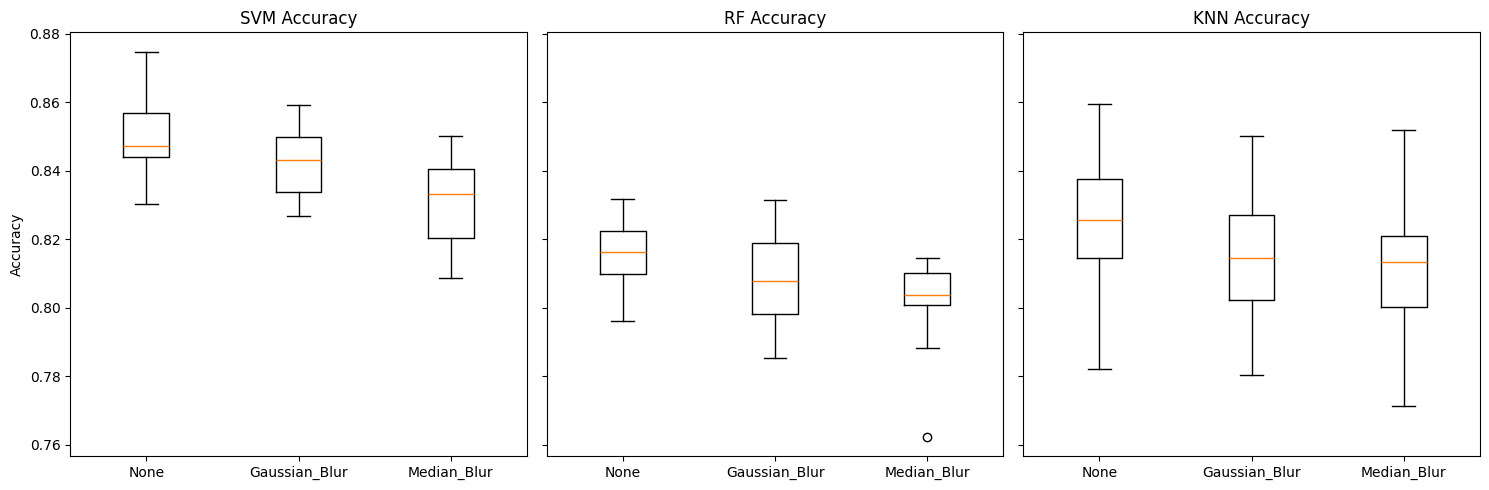

/tmp/ipykernel_24373/257706186.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=d_methods)
/tmp/ipykernel_24373/257706186.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=d_methods)
/tmp/ipykernel_24373/257706186.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=d_methods)


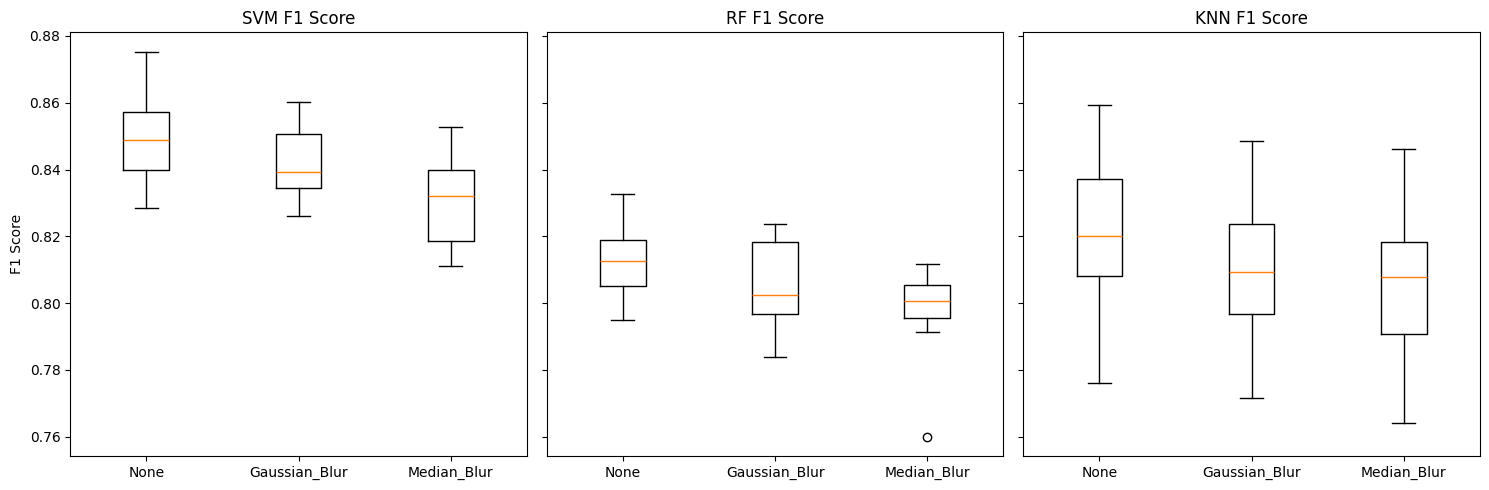

/tmp/ipykernel_24373/257706186.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=d_methods)
/tmp/ipykernel_24373/257706186.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=d_methods)
/tmp/ipykernel_24373/257706186.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=d_methods)


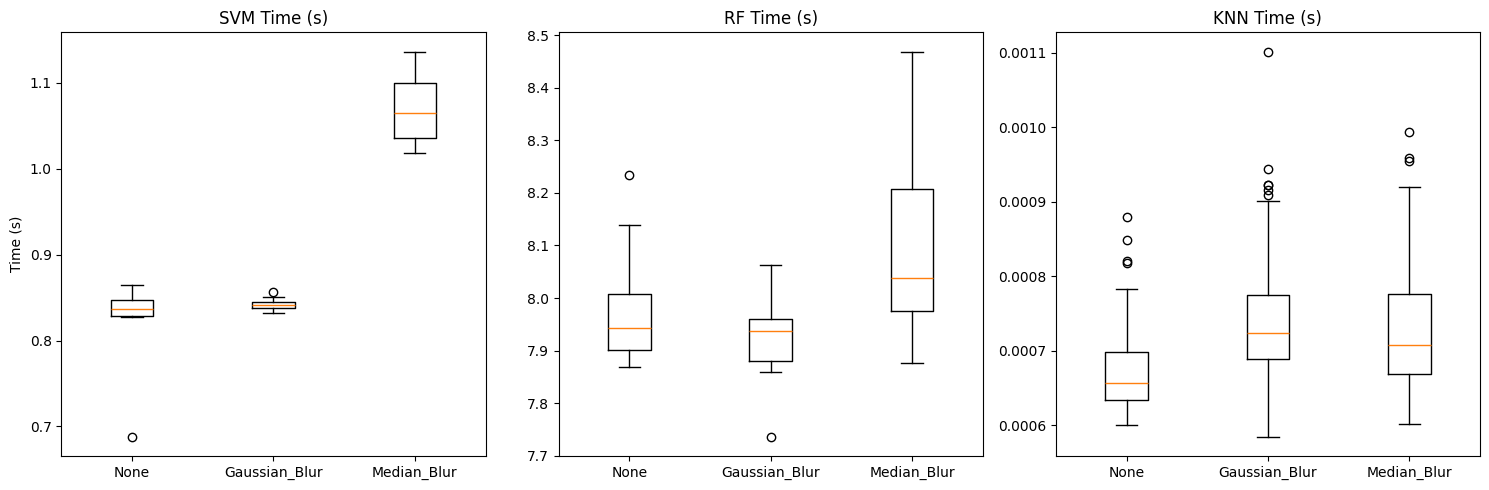

In [13]:
# Side-by-side box plots for accuracy, f1, and classfication time
import matplotlib.pyplot as plt

ls_model_names = ["SVM", "RF", "KNN"]
n_models = len(ls_model_names)
d_methods = list(models_denoising_accuracies["SVM"].keys())

d_method_names = denoise_methods.keys()

# 1) Accuracy boxplots
fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 5), sharey=True)
for ax, name, d_method_name in zip(axes, ls_model_names, d_method_names):
    data = [models_denoising_accuracies[name][m] for m in d_methods]
    ax.boxplot(data, labels=d_methods)
    ax.set_title(f"{name} Accuracy")
    #ax.set_xlabel(d_method_name)
    if ax is axes[0]:
        ax.set_ylabel("Accuracy")
plt.tight_layout()
plt.show()

# 2) F1 score boxplots
fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 5), sharey=True)
for ax, name, d_method_name in zip(axes, ls_model_names, d_method_names):
    data = [models_denoising_f1_scores[name][m] for m in d_methods]
    ax.boxplot(data, labels=d_methods)
    ax.set_title(f"{name} F1 Score")
    #ax.set_xlabel(d_method_name)
    if ax is axes[0]:
        ax.set_ylabel("F1 Score")
plt.tight_layout()
plt.show()

# 3) Classification time boxplots
fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 5), sharey=False)
for ax, name, d_method_name in zip(axes, ls_model_names, d_method_names):
    data = [models_denoising_classification_times[name][m] for m in d_methods]
    ax.boxplot(data, labels=d_methods)
    ax.set_title(f"{name} Time (s)")
    #ax.set_xlabel(d_method_name)
    if ax is axes[0]:
        ax.set_ylabel("Time (s)")
plt.tight_layout()
plt.show()

### Validation Loss Curve

In [ ]:
plt.figure()
for denoise, val_losses in val_loss_curves:
    plt.plot(val_losses, label=denoise)
df = pd.DataFrame(val_loss_curves)

plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Curve For each Denoiser')
plt.legend()
plt.grid(True)
plt.show()

### Confusion Matrix(How?)